# Metropolis Algorithm
Consider the data `data_ex05.npy`. Assume $X$ is distributed according to a normal:
$$
    f_X(x|\mu, \sigma)=\frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{1}{2}\frac{(x-\mu)^2}{\sigma^2}}
$$
where 
$$
    f_{prior}(\mu) \sim \mathcal{N}(m, s^2)
$$
with $m=4$, $s=2$, and
$$
    f_{prior}(\sigma) \sim I\mathcal{\Gamma}(\alpha, \beta)
$$
with $\alpha=2$, $\beta=1$. Here $I\mathcal{\Gamma}$ denotes the Inverse-gamma distribution, which is characterized by the following probability density function, defined over the support $x>0$:
$$
    f_{I\mathcal{\Gamma}}(x|\alpha, \beta) = \frac{\beta^\alpha}{\Gamma(\alpha)}(1/x)^{\alpha+1}e^{-\beta/x}
$$

## Task
Estimate $\mu$, $\sigma$ as posterior averages (with errors given by posterior standard deviations) from the data, using Metropolis algorithm to sample. In other words, using Metropolis algorithm sample
$$
    f(\mu, \sigma | x) \propto f_X(x|\mu, \sigma)\cdot f_{prior}(\mu) \cdot f_{prior}(\sigma)
$$
The proposal step $T(\mu', \sigma', \mu, \sigma)$ can be any random move:
$$
\begin{align*}
    \mu &\to \mu' \\
    \sigma &\to \sigma'
\end{align*}
$$
For instance, $(\mu', \sigma')$ are sampled normally around $(\mu, \sigma)$ with std. $\tau$:
$$
    (\mu', \sigma') \sim \mathcal{N}\left((\mu, \sigma), \tau^2\mathbb{I}\right) \iff \begin{cases}
        \mu' &\sim \mathcal{N}\left(\mu, \tau^2\right) \\
        \sigma' &\sim \mathcal{N}\left(\sigma, \tau^2\right)
    \end{cases}
$$ 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import math 

from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm

data = np.load('./data/data_ex05.npy')
print('There are %i data points' %len(data))

There are 10000 data points


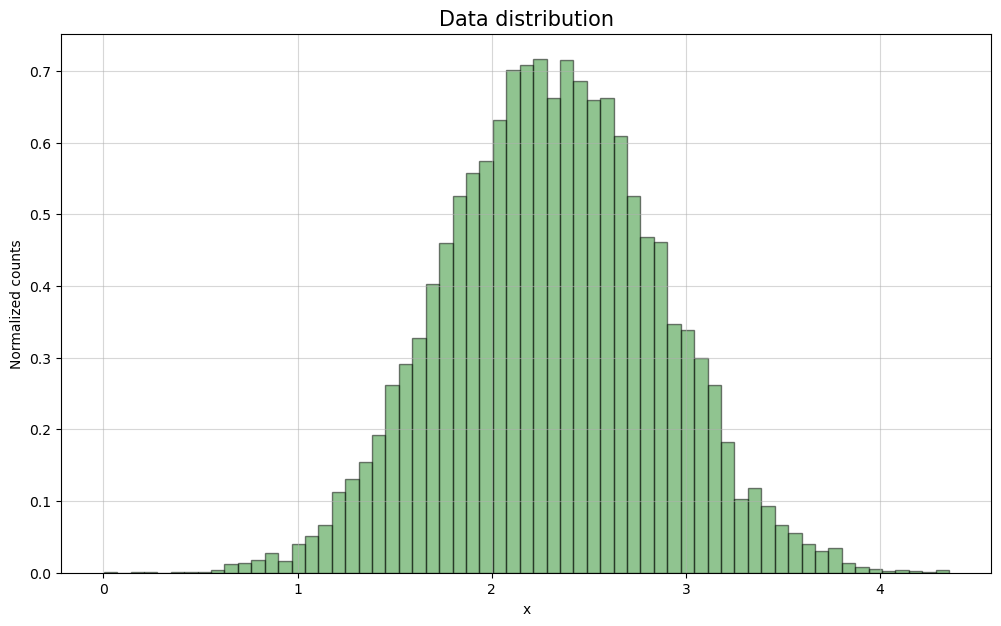

In [15]:
# plot data distribution 
fig, ax = plt.subplots(figsize=(12, 7))

hist_val_div = ax.hist(data, bins='fd', edgecolor='black', alpha=0.5, density=True, color='forestgreen')

ax.set_xlabel('x', fontsize=10)
ax.set_ylabel('Normalized counts', fontsize=10)
ax.grid(alpha=0.5)
ax.set_title('Data distribution', fontsize=15)

plt.show()

In [3]:
def log_likelihood(x, mu, sigma):
    return np.log(1/np.sqrt(2*np.pi*sigma))-0.5*(x-mu)**2/sigma**2

def log_prior_mu(mu, m, s):
    return np.log(1/np.sqrt(2*np.pi*s))-0.5*(mu-m)**2/s**2

def log_prior_sigma(sigma, alpha, beta):
    def inverse_gamma(x, alpha_, beta_):
        return beta_**alpha_/math.gamma(alpha_)*(1/x)**(alpha+1)*np.exp(-beta_/x)
    
    return np.log(inverse_gamma(sigma, alpha, beta))

def log_posterior(mu, sigma, x, m=4, s=2, alpha=2, beta=1):
    return np.sum(log_likelihood(x, mu, sigma)) + log_prior_mu(mu, m, s) + log_prior_sigma(sigma, alpha, beta)

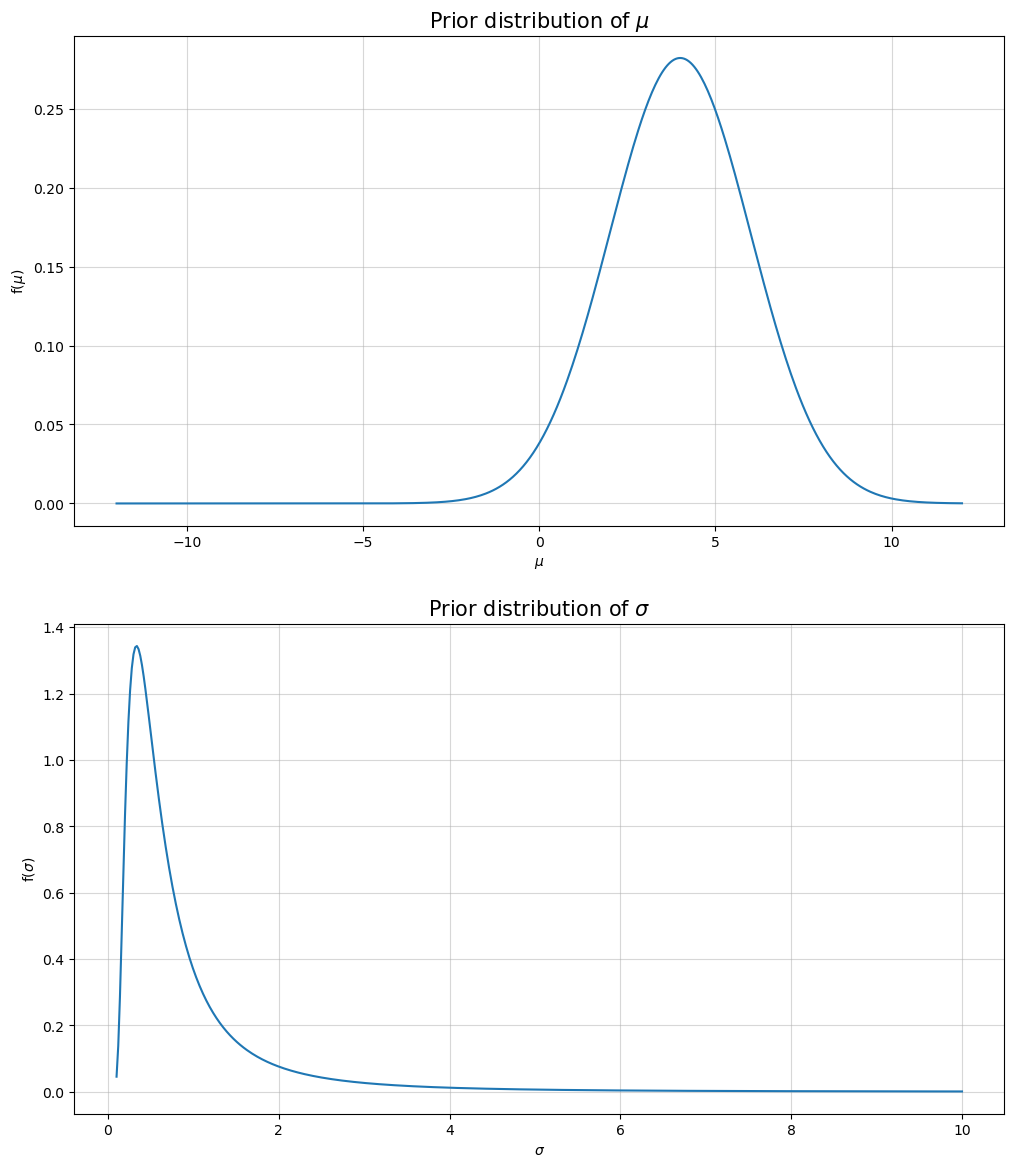

In [4]:
x_mu  = np.linspace(-12, 12, 500)
x_sigma  = np.linspace(0.1, 10, 500)

_, ax = plt.subplots(2, 1, figsize=(12, 14))
ax[0].plot(x_mu, np.exp(log_prior_mu(x_mu, m=4, s=2)))
ax[1].plot(x_sigma, np.exp(log_prior_sigma(x_sigma, alpha=2, beta=1)))

param_str = ['$\mu$', '$\sigma$']

for i in range(2):
    ax[i].set_title('Prior distribution of ' + param_str[i], fontsize=15)
    ax[i].set_xlabel(param_str[i], fontsize=10)
    ax[i].set_ylabel('f('+param_str[i]+')', fontsize=10)
    ax[i].grid(alpha=0.5)
    
plt.show()

In [5]:
def metropolis(p0, n_samples, burn_in, x=data, log_func_post=log_posterior):
    '''
    INPUTS:
    p0            -> initial state of the Markov Chain, [mu_0, sigma_0]
    n_samples     -> number of required samples
    burn_in       -> discarded initial samples
    x             -> data samples
    log_func_post -> function returning a ln of the posterior distribution, not normalized with the evidence
    
    OUTPUT: 
    f_sampled     -> MCMC chain, shape (2, n_samples)
    r_accept      -> acceptance rate (computed only after the burn in)
    
    '''
    
    p_current = p0
    f_current = log_func_post(mu=p_current[0], sigma=p_current[1], x=x)  
    
    tau = 0.005
    
    # initialize the chain object
    f_sampled = np.zeros((2, n_samples))
    
    # acceptance/rejection rate
    n_accept = 0
    
    # MCMC algorithm
    i = 0
    while i<(burn_in + n_samples):
        # draw random sample
        p_prop = np.random.multivariate_normal(mean=p_current, cov=tau*np.eye(2))
        
        # Metropolis step
        f_prop = log_posterior(mu=p_prop[0], sigma=p_prop[1], x=x)
        logMR =  f_prop - f_current
        
        if logMR >= 0 or logMR >= np.log(np.random.uniform(0, 1)):
            p_current = p_prop
            f_current = f_prop 
            if i >= burn_in: 
                n_accept += 1
            
        if i >= burn_in:
            f_sampled[:, i-burn_in] = p_current
        
        i += 1
    
    r_accept = n_accept/n_samples
    
    return f_sampled, r_accept

In [6]:
p0 = np.array([4, 1])
burn_in = 200
n_steps = 100000

chains, rate_accept = metropolis(p0, n_samples=n_steps, burn_in=burn_in)
print('The acceptance rate is %.1f%%' %(rate_accept*100))

The acceptance rate is 2.4%


## Marginal distributions

In [7]:
def hist_marginals(one_chain_samples, xlabel):
    fig, ax = plt.subplots(figsize=(12, 7))
    
    hist_ = ax.hist(one_chain_samples, bins='fd', edgecolor='black', alpha=0.5, density=True, color='firebrick')
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel('f('+xlabel+')', fontsize=10)
    ax.grid(alpha=0.5)

    ax.set_title('Posterior distribution of '+xlabel, fontsize=15)

    plt.show()
    
    variable_mean = np.mean(one_chain_samples)
    variable_std  = np.std(one_chain_samples)
    
    return variable_mean, variable_std
    
    

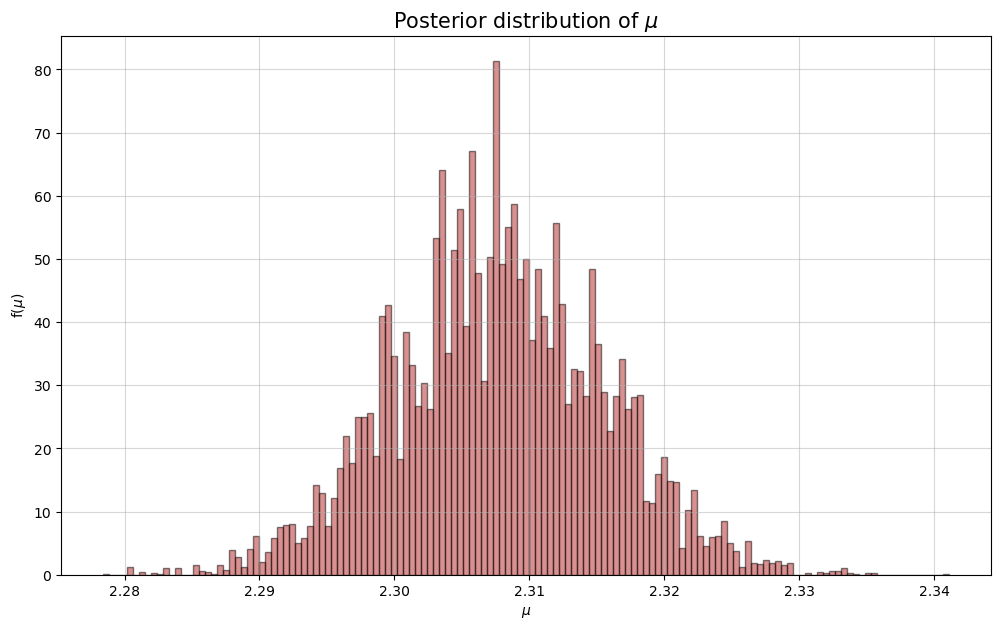

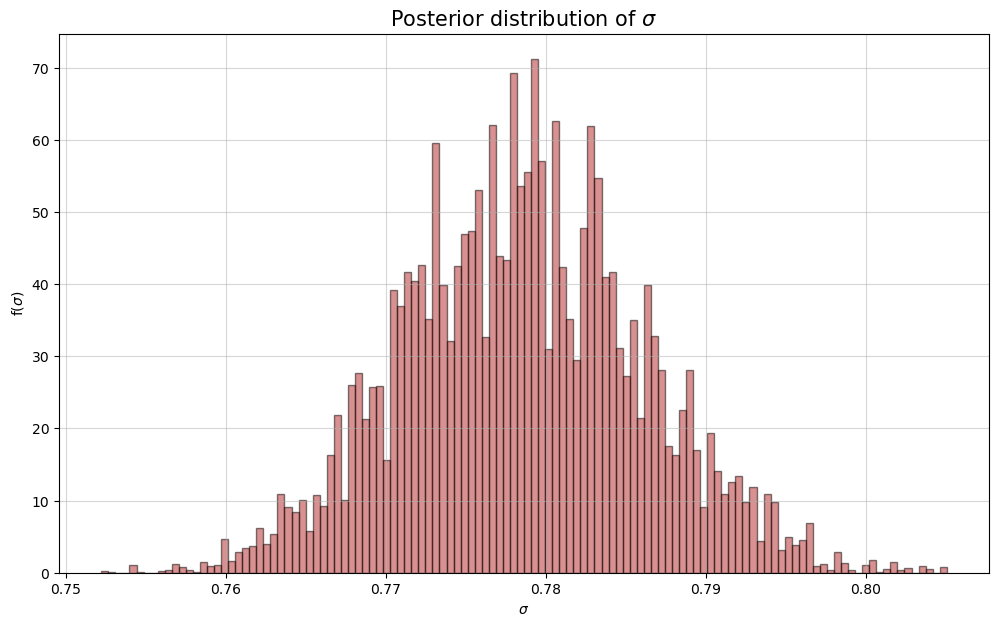

In [8]:
mu_mean, mu_std = hist_marginals(chains[0, :], '$\mu$')
sg_mean, sg_std = hist_marginals(chains[1, :], '$\sigma$')

In [9]:
print('mu    = %.3f +- %.3f' %(mu_mean, mu_std))
print('sigma = %.3f +- %.3f' %(sg_mean, sg_std))

mu    = 2.308 +- 0.008
sigma = 0.779 +- 0.008


## Chain analysis

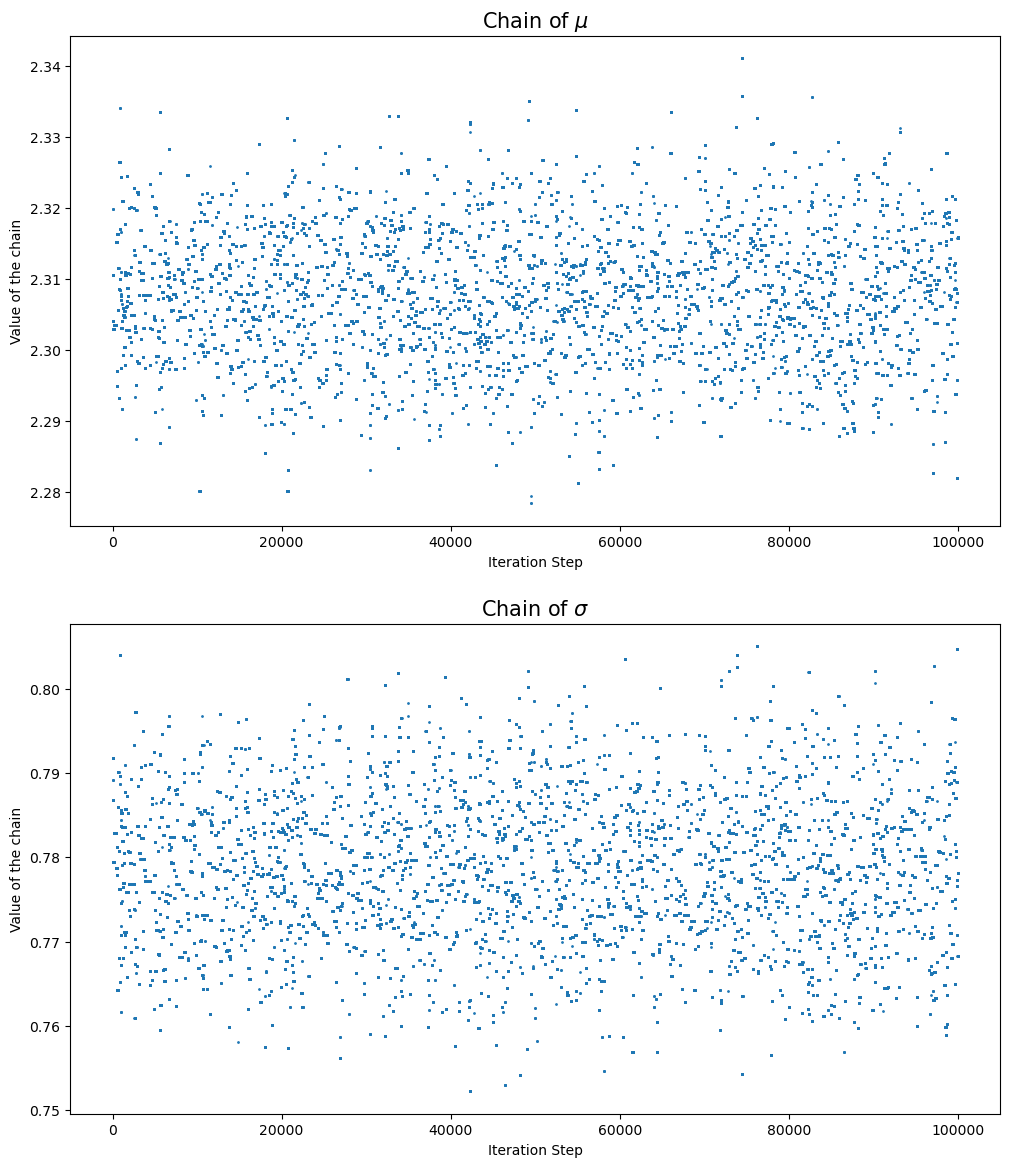

In [10]:
def plot_chain(chain_samples, var_names):

    fig, ax = plt.subplots(2, 1, figsize=(12, 14))
    
    for i in range(2):
        ax[i].scatter(range(0, chain_samples.shape[1]) , chain_samples[i, :], s=1)
        ax[i].set_xlabel('Iteration Step', fontsize=10)
        ax[i].set_ylabel('Value of the chain', fontsize=10)
        ax[i].set_title('Chain of '+ var_names[i], fontsize=15)
        
    plt.show()
    
plot_chain(chains, ['$\mu$', '$\sigma$'])

## Looking for correlations

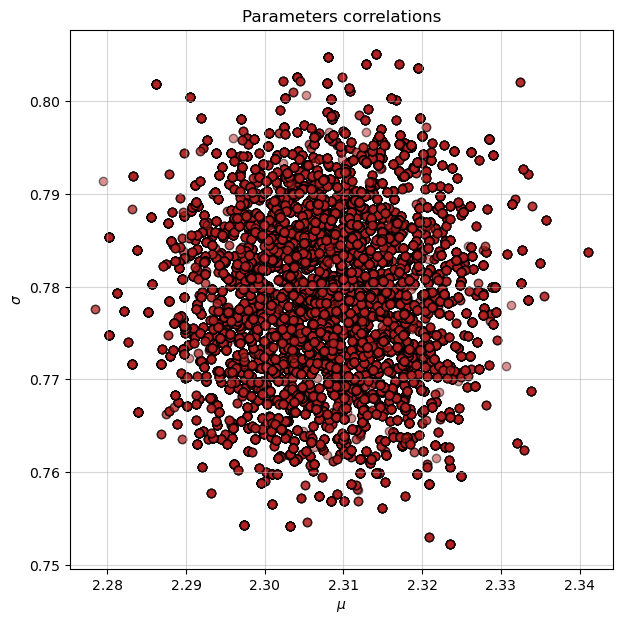

In [11]:
fig, ax = plt.subplots(figsize=(7, 7))
    
ax.scatter(chains[0, :], chains[1, :], edgecolors = 'black', facecolors='firebrick', alpha=0.5)
ax.set_xlabel('$\mu$', fontsize=10)
ax.set_ylabel('$\sigma$', fontsize=10)
ax.grid(alpha=0.5)

ax.set_title('Parameters correlations')

plt.show()


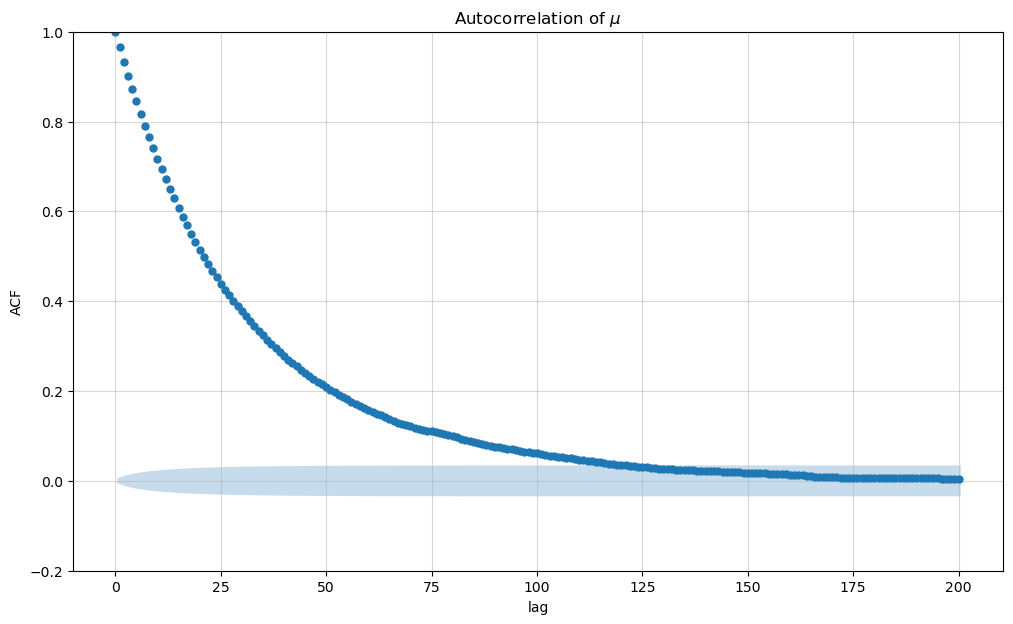

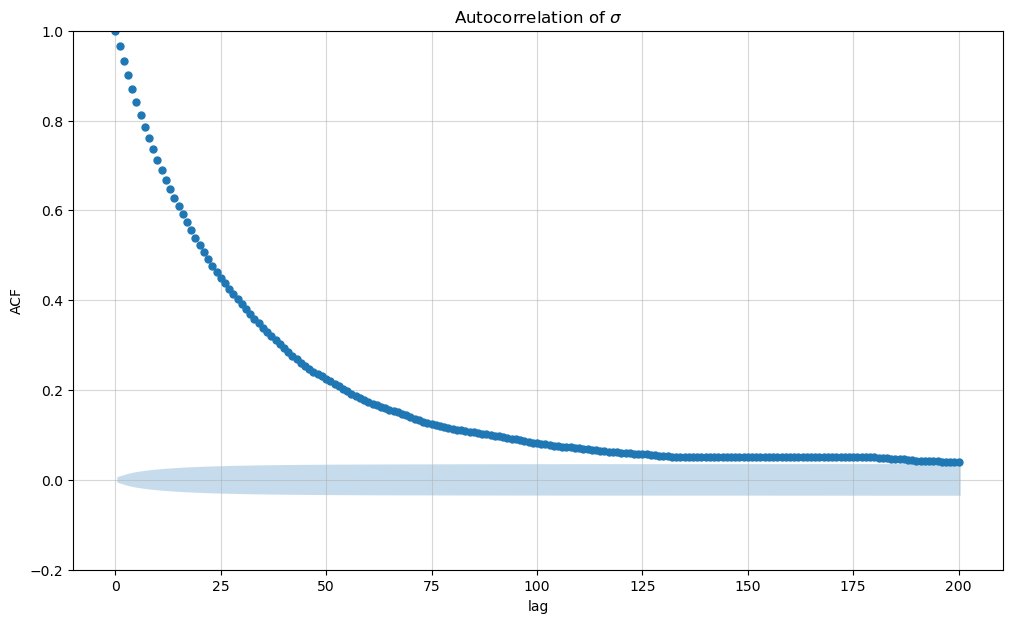

In [12]:
plot_acf(
    chains[0, :], lags=200, 
    use_vlines=False, title='Autocorrelation of $\mu$'
)
fig = plt.gcf()
fig.set_size_inches(12, 7)

ax = plt.gca()
ax.grid(alpha=0.5)
ax.set_ylim(-0.2)
ax.set_xlabel('lag')
ax.set_ylabel('ACF')

plt.show()


plot_acf(
    chains[1, :], lags=200, 
    use_vlines=False, title='Autocorrelation of $\sigma$'
)
fig = plt.gcf()
fig.set_size_inches(12, 7)

ax = plt.gca()
ax.grid(alpha=0.5)
ax.set_ylim(-0.2)
ax.set_xlabel('lag')
ax.set_ylabel('ACF')

plt.show()


## Comparison with data

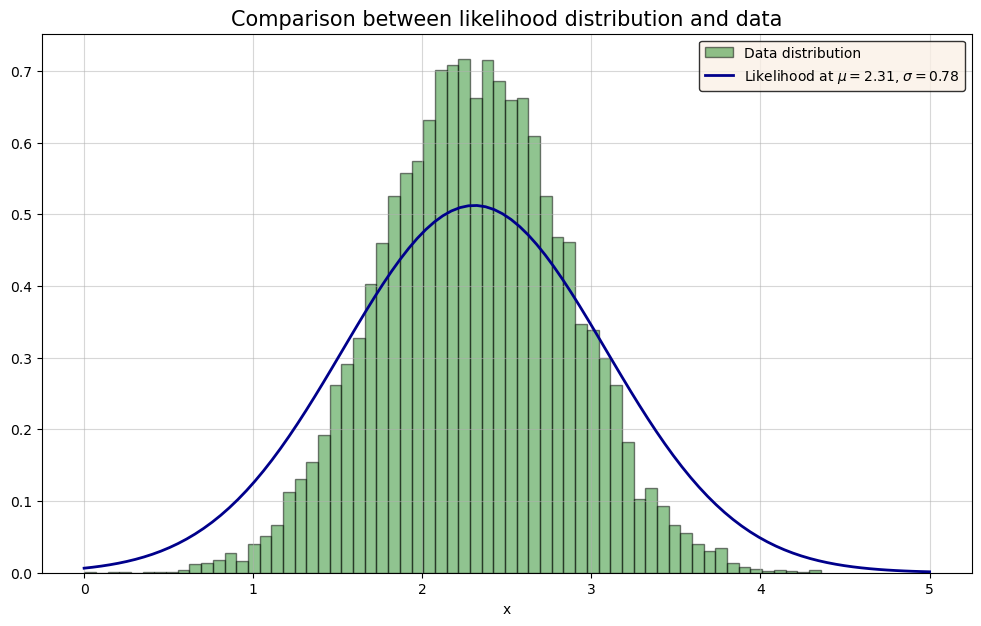

In [17]:
# plot likelihood with found parameters (posterior averages)
x_plot = np.linspace(0, 5, 100)
y_plot = norm.pdf(x_plot, loc=mu_mean, scale=sg_mean)

fig, ax = plt.subplots(figsize=(12, 7))

hist_val_div = ax.hist(data, bins='fd', edgecolor='black', alpha=0.5, density=True, color='forestgreen', label='Data distribution')
ax.plot(x_plot, y_plot, color='darkblue', linewidth=2, label='Likelihood at $\mu=%.2f$, $\sigma=%.2f$' %(mu_mean, sg_mean))

ax.set_xlabel('x', fontsize=10)
# ax.set_ylabel('f(x)', fontsize=10)
ax.grid(alpha=0.5)
ax.set_title('Comparison between likelihood distribution and data', fontsize=15)
ax.legend(edgecolor='black', facecolor='linen', fontsize=10, loc ='upper right')

plt.show()